## - this was made to create function to convert keypoints to video to inspect some things

# 1 - install dependencies

In [67]:
import numpy as np
import cv2 
import os
import mediapipe as mp
import tensorflow as tf 
from tensorflow import keras
import matplotlib.pyplot as plt
import time
import pandas as pd

# 2 - keypoints extractions and drawing

### 

- link to mediapipe documentation and info about keypoints numbers
- https://google.github.io/mediapipe/solutions/hands.html




- link to mediapipe code for drawing (to draw the point myself)
- https://github.com/google/mediapipe/blob/master/mediapipe/python/solutions/drawing_utils.py



In [277]:
# points = results.pose_landmarks.landmark[0]

In [278]:
# mp_drawing._normalized_to_pixel_coordinates(points.x,points.y,512,512)

(160, 207)

In [279]:
# extract_keypoints(results)

array([0.31424871, 0.40516621, 0.34958363, 0.33295104, 0.27392039,
       0.35212395, 0.57817125, 0.55916786, 0.68416971, 0.97159886,
       0.73283637, 1.35949564, 0.13666716, 0.62433493, 0.06154023,
       0.99031198, 0.25215438, 0.65857196, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.2916199 , 0.62908918, 0.2574822 , 0.48344749, 0.29246381,
       0.40439418, 0.34092072, 0.43980053, 0.33933544, 0.40211019,
       0.37682196, 0.46833116, 0.3664979 , 0.42915609, 0.40017185,
       0.50406665, 0.39019808, 0.46095249, 0.41237393, 0.54100579,
       0.4069846 , 0.49963647])

In [69]:
    
pose_selected_landmarks = [
    [0,2,5,11,13,15,12,14,16],
    [0,2,4,5,8,9,12,13,16,17,20],
    [0,2,4,5,8,9,12,13,16,17,20],

]

def draw_updated_styled(image,results):
    image_rows, image_cols, _ = image.shape
    
    original_landmarks = [
        results.pose_landmarks,
        results.left_hand_landmarks,
        results.right_hand_landmarks
    ]

    
    for shape in range(3):
        if(original_landmarks[shape]):
            lis = original_landmarks[shape].landmark
            for idx in pose_selected_landmarks[shape]:
                point = lis[idx]
                landmark_px = mp_drawing._normalized_to_pixel_coordinates(point.x, point.y,
                                                           image_cols, image_rows)

                cv2.circle(image, landmark_px, 2, (0,0,255),
                         4)

                
                
def extract_keypoints(results):
    
    original_landmarks = [
        results.pose_landmarks,
        results.left_hand_landmarks,
        results.right_hand_landmarks
    ]
    
    outputs = []
    for shape in range(3):
        if(original_landmarks[shape]):
            lis = original_landmarks[shape].landmark
            pose = np.array([ [lis[res].x,lis[res].y] for res in pose_selected_landmarks[shape] ]).flatten()
        else:
            pose = np.zeros(len(pose_selected_landmarks[shape])*2)
        outputs.append(pose)
    return np.concatenate([outputs[0],outputs[1],outputs[2]])
            
    
 
        

In [70]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

num_hand_marks = 21
num_pose_marks = 33


# holistic model process image and return the results as keypoints
def mediapipe_detection(image,model):
    image  = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image  = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
    return image,results
    
def draw_styled_landmarks(image,results):
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 
    

# read the keypoints and extract them and process them
def old_extract_keypoints(results):
    # extract pose marks
    if results.pose_landmarks:
        pose = np.array([ [res.x,res.y,res.visibility] for res in results.pose_landmarks.landmark ]).flatten()
    else:
        pose = np.zeros(num_pose_marks*3)
    
    # extract left hand
    if results.left_hand_landmarks:
        left_hand = np.array([ [res.x,res.y] for res in results.left_hand_landmarks.landmark ]).flatten()
    else:
        left_hand = np.zeros(num_hand_marks*2)
        
        
    # extract right hand
    if results.right_hand_landmarks:
        right_hand = np.array([ [res.x,res.y] for res in results.right_hand_landmarks.landmark ]).flatten()
    else:
        right_hand = np.zeros(num_hand_marks*2)
    
    return np.concatenate([pose,left_hand,right_hand])
    

# 3 - read and process data

In [71]:
data_path = "../../../data/Datasets/"

train_labels = pd.read_csv(os.path.join(data_path,"train_labels.csv"),names=['sample','id'])
validation_labels = pd.read_csv(os.path.join(data_path,"validation_labels.csv"),names=['sample','id'])
test_labels = pd.read_csv(os.path.join(data_path,"test_labels.csv"),names=['sample','id'])
class_id = pd.read_csv(os.path.join(data_path,"class_id.csv"))


    
train_path = os.path.join(data_path,"train")
val_path = os.path.join(data_path,"val")
test_path = os.path.join(data_path,"test")



In [72]:
def check_file(file_path):
    try:
        f = open(file_path)
        f.close()
        return True
    except IOError:
        return False
    
    

def construct_path(file,path="train"):
    return os.path.join(os.path.join(data_path,path),file+"_color.mp4")
    

### 3.1 collect data that in classes 0,1,2 and available in the data/train directory

In [73]:
# for 10 signs

n_actions = 10
actions = list(class_id['EN'][:n_actions])
actions[3] = "meal"
dic={}
for i,action in enumerate(actions):
    dic[action]=i
    

In [74]:
actions

['sister',
 'hurry',
 'hungry',
 'meal',
 'brother',
 'tree',
 'heavy',
 'cry',
 'family',
 'wise']

In [75]:
dic

{'sister': 0,
 'hurry': 1,
 'hungry': 2,
 'meal': 3,
 'brother': 4,
 'tree': 5,
 'heavy': 6,
 'cry': 7,
 'family': 8,
 'wise': 9}

In [79]:
def get_data(value,file_path,label_name):
    if file_path=="train":
        label_dic = train_labels
    elif file_path=="val":
        label_dic = validation_labels
    elif file_path=="test":
        label_dic = test_labels
        
    
    data =  label_dic[label_dic['id']==value]
    lis =  [construct_path(i,file_path) for i in  (data['sample'])]
    data =  [i for i in lis if check_file(i)]
    return data,[label_name for i in data]
    

def get_list(d,cat):
    arr_x=[]
    arr_y=[]
    for index,value in enumerate(d):
        
        data,labels = get_data(value,cat,value)
        arr_x.extend(data)
        arr_y.extend(labels)
    return arr_x,arr_y

In [80]:


d = [6,7,8,9]



train_X,train_Y = get_list(d,"train")
val_X,val_Y = get_list(d,"val")
test_X,test_Y = get_list(d,"test")


In [81]:
print(
    len(train_X ),
len(train_Y),
len(val_X ),
len(val_Y),
len(test_X ),
len(test_Y)
)

494 494 72 72 68 68


### 3.2 process videos into frames and label to cateogries

In [12]:


def capture_frames(video_path):
    video = cv2.VideoCapture(video_path)
    video_length = int(video.get(cv2.CAP_PROP_FRAME_COUNT)) - 1
    # count = 0
    # frame_rate = video.get(cv2.CAP_PROP_FRAME_COUNT)

    count=0
    frames = []
    while video.isOpened():
      # frame_id = video.get(0)
        ret, frame = video.read()
        
        if not ret:
            continue
        frames.append(frame)
        count += 1
        # If there are no more frames left
        if (count > (video_length-1)):
          # Release the feed
          video.release()
        # if frame_id % math.floor(1) == 0:
        #     file_name = f"{video_path}_frame_{count}.jpg"
        #     count += 1
        #     # print(f"File name: {file_name}")
        #     frames.append(frame)
        #     # cv2.imwrite(file_name, frame)
    video.release()
    return np.array(frames)


def get_frames(video_path,num_frames):
    frames = capture_frames(video_path)
    video_length = len(frames)
    steps = video_length/num_frames
    count=0
    new_frames=[]
    while count<video_length:
        frame = frames[int(count)]
#         frame = cv2.resize(frame, (256, 256))
#         frame =  (frame/255.0).astype(np.float16)
        new_frames.append(frame)
        count+=steps

    s = np.array(new_frames[:num_frames])
    return np.array(new_frames[:num_frames])


In [13]:
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
holistic = mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5)



datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        #horizontal_flip=True,
        fill_mode='nearest')



def transform(frame):
    for trans_frame in datagen.flow(np.expand_dims(frame, axis=0)):
        return np.squeeze(trans_frame.astype(np.uint8), axis=0)
    



def get_frames_aug(video_path,num_frames):
    frames = capture_frames(video_path)
    video_length = len(frames)
    steps = video_length/num_frames
    count=0
    new_frames=[]
    while count<video_length:
        frame = frames[int(count)]
        
        new_frames.append(transform(frame))
        count+=steps

    return np.array(new_frames[:num_frames])




INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [14]:
from PIL import Image

holistic = mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5)

def extract_keypoints_video(path,i=-1):
    
    if(i!=-1):
        print(i,end="\r")
    
    if(type(path) == str):
        frames = get_frames_aug(path,20)
    else:
        frames = path 
    output_key_points=[]
    
    
    for frame in frames:
        image, results = mediapipe_detection(frame, holistic)
        output_key_points.append(extract_keypoints(results))
    return np.array(output_key_points)


    

# Test new pose

In [20]:
def convert_keypoints_to_frame(key_points):
    image_rows, image_cols = 512,512
    image = np.zeros((512,512,3)) + 255
    

    for points in range(31):
        point = {"x":key_points[points*2],"y":key_points[points*2+1]}
        landmark_px = mp_drawing._normalized_to_pixel_coordinates(point['x'], point['y'],
                                                           image_cols, image_rows)

        cv2.circle(image, landmark_px, 2, (0,0,255),
                 4)
    return image


In [294]:
results.pose_landmarks.landmark[0]

x: 0.3142487108707428
y: 0.4051662087440491
z: -1.0271275043487549
visibility: 0.9993081092834473

In [90]:
trans_frame = transform(frame)

In [94]:
np.min(trans_frame)

0

In [88]:
# check that reduced_keypoints_2 is updaed
train = np.load(os.path.join("reduced_keypoints_2","train_labels.npy"))
val = np.load(os.path.join("reduced_keypoints_2","val_labels.npy"))
test = np.load(os.path.join("reduced_keypoints_2","test_labels.npy"))
print(train.shape,val.shape,test.shape)

In [94]:
# create final_reduced

for name in ['train_labels.npy',"val_labels.npy","test_labels.npy"]:
    d1 = np.load(os.path.join("reduced_keypoints",name))
    d2 = np.load(os.path.join("reduced_keypoints_2",name))
    np.save(os.path.join("final_reduced",name),np.concatenate([d1,d2]))



In [101]:
# check that final_reduced is updaed
train = np.load(os.path.join("final_reduced","train_labels.npy"))
val = np.load(os.path.join("final_reduced","val_labels.npy"))
test = np.load(os.path.join("final_reduced","test_labels.npy"))
print(train.shape,val.shape,test.shape)
train = np.load(os.path.join("final_reduced","train_features.npy"))
val = np.load(os.path.join("final_reduced","val_features.npy"))
test = np.load(os.path.join("final_reduced","test_features.npy"))
print(train.shape,val.shape,test.shape)

(1241,) (190,) (168,)
(1241, 20, 62) (190, 20, 62) (168, 20, 62)


In [98]:
val

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])

In [93]:
videos = np.load(os.path.join("reduced_keypoints_2","train_features.npy"))
labels = np.load(os.path.join("reduced_keypoints_2","train_labels.npy"))

In [51]:
# frames = get_frames_aug(train_X[34],20)
v1 = videos[-150]


for frame in v1:
    image = convert_keypoints_to_frame(frame)
    
    cv2.imshow("frame",image)
    if cv2.waitKey(1000) & 0xFF == ord('q'):
        break



cv2.destroyAllWindows()

In [50]:
labels[-150]

8

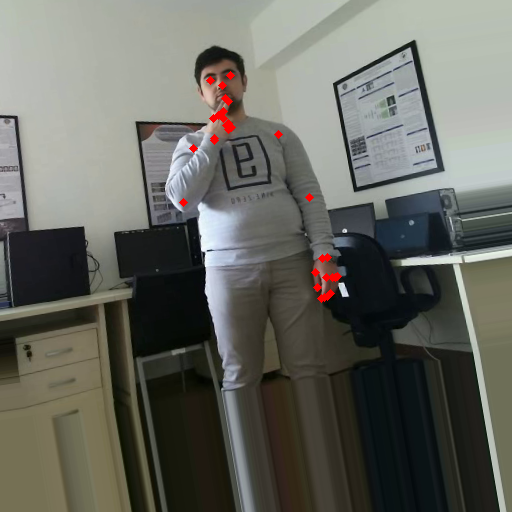

In [15]:
frames = get_frames_aug(train_X[34],20)
frame = frames[7]

image, results = mediapipe_detection(frame, holistic)
ex = extract_keypoints(results)

draw_updated_styled(image, results)


image  = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

from PIL import Image

Image.fromarray(image)


In [44]:
ex

array([0.65825856, 0.45923039, 0.67483896, 0.43934199, 0.64051181,
       0.44361699, 0.75770265, 0.56956124, 0.79618555, 0.71626335,
       0.80249506, 0.841093  , 0.57748812, 0.57267493, 0.55327159,
       0.69705969, 0.635427  , 0.55231118, 0.81597841, 0.84940779,
       0.78846276, 0.88067532, 0.78780055, 0.91195786, 0.8095783 ,
       0.89305604, 0.79487228, 0.93540299, 0.8211593 , 0.89486694,
       0.80068743, 0.93478698, 0.82757837, 0.89479673, 0.80664223,
       0.93160516, 0.83064497, 0.89399612, 0.8115173 , 0.92605335,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])

In [194]:
cap = cv2.VideoCapture(0);

while cap.isOpened():

    ret, frame = cap.read()
    if(not ret):break
        
    frame = transform(frame)
    image, results = mediapipe_detection(frame, holistic)
    # output_key_points.append(extract_keypoints(results))


    # draw_styled_landmarks(frame, results)
    draw_updated_styled(frame, results)
    
    cv2.imshow("frame",frame)
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [170]:
cap.release()
cv2.destroyAllWindows()

### 3.3 - extract the keypoints and save them in train

In [24]:
x = extract_keypoints_video(train_X[0])

In [ ]:
# collect 7 different transformations
for v in range(1,8):
    dir_name = os.path.join("final_aug",str(v))
    try:
        os.mkdir(dir_name)
    except:
        pass

    os.listdir(dir_name)

    if "train_features.npy" in os.listdir(dir_name):
        print(f"V{v} exists")
        train_data = np.load(os.path.join(dir_name,"train_features.npy"))
        train_labels = np.load(os.path.join(dir_name,"train_labels.npy"))
    else:
        print(f"Start saving for V{v}")
        train = np.array([extract_keypoints_video(path,f'Train iteration : {i+1}/{len(train_X)}') for i,path in enumerate(train_X) ])
        np.save(os.path.join(dir_name,'train_features.npy'), train) 
        np.save(os.path.join(dir_name,"train_labels.npy"),np.array(train_Y))
        print(f"Training Finished for V{v}")

V1 exists
V2 exists
V3 exists
V4 exists
V5 exists
Start saving for V6


# combining the 5 transformed data

In [32]:
train_data = np.concatenate([
    np.load(os.path.join("final_aug","1",'train_features.npy')),
    np.load(os.path.join("final_aug","2",'train_features.npy')),
    np.load(os.path.join("final_aug","3",'train_features.npy')),
    np.load(os.path.join("final_aug","4",'train_features.npy')),
    np.load(os.path.join("final_aug","5",'train_features.npy')),
    np.load(os.path.join("final_reduced",'train_features.npy')),
])

train_labels = np.concatenate([
    np.load(os.path.join("final_aug","1",'train_labels.npy')),
    np.load(os.path.join("final_aug","2",'train_labels.npy')),
    np.load(os.path.join("final_aug","3",'train_labels.npy')),
    np.load(os.path.join("final_aug","4",'train_labels.npy')),
    np.load(os.path.join("final_aug","5",'train_labels.npy')),
    np.load(os.path.join("final_reduced",'train_labels.npy')),
])
val_data    = np.load(os.path.join("final_reduced",'val_features.npy')) 
val_labels  = np.load(os.path.join("final_reduced",'val_labels.npy')) 
test_data   = np.load(os.path.join("final_reduced",'test_features.npy')) 
test_labels = np.load(os.path.join("final_reduced",'test_labels.npy'))  

In [33]:
print(
train_data.shape,
    train_labels.shape,
    val_data.shape,
    val_labels.shape,
    test_data.shape,
    test_labels.shape
    
)

(7446, 20, 62) (7446,) (190, 20, 62) (190,) (168, 20, 62) (168,)


### 3.4 shuffle the data

In [222]:
perm = np.random.permutation(len(train_data))

train_X = train_data[perm]
train_Y = train_labels[perm]
val_X = val_data
val_Y = val_labels
test_X = test_data
test_Y = test_labels


In [223]:
print(
train_X.shape,
train_Y.shape,
val_X.shape,
val_Y.shape,
test_X.shape,
test_Y.shape,
)

(4482, 20, 62) (4482,) (118, 20, 62) (118,) (100, 20, 62) (100,)


# 4 - build and train the model

In [257]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Input,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard,ModelCheckpoint,EarlyStopping

best_model_file_name = os.path.join("data_aug","arc_1.h5")

tb_callback = TensorBoard(log_dir=os.path.join('Logs'))
checkpoint = ModelCheckpoint(os.path.join(best_model_file_name), monitor='loss', verbose=0,
    save_best_only=True, mode='auto', save_freq=1)
earlyStopping = EarlyStopping(monitor='loss', patience=40)

In [258]:
actions

['sister', 'hurry', 'hungry', 'meal', 'brother', 'tree']

In [255]:
def first_model():
    input_layer = Input(shape=(20,62))
    layer = LSTM(64,return_sequences=True,activation="relu")(input_layer)
    layer = LSTM(128,return_sequences=True,activation="relu")(layer)
    layer = LSTM(256,return_sequences=True,activation="relu")(layer)
    layer = LSTM(128,return_sequences=True,activation="relu")(layer)
    layer = LSTM(64,return_sequences=False,activation="relu")(layer)
    layer = Dense(64,activation="relu")(layer)
    layer = Dense(32,activation="relu")(layer)
    layer = Dense(len(actions),activation="softmax")(layer)

    model = Model(inputs=input_layer,outputs=layer)
    model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model


def second_model():
    input_layer = Input(shape=(20,62))
    layer = LSTM(64,return_sequences=True,activation="relu")(input_layer)
    layer = LSTM(128,return_sequences=True,activation="relu")(layer)
    layer = Dropout(0.5)(layer)
    layer = LSTM(256,return_sequences=True,activation="relu")(layer)
    layer = Dropout(0.5)(layer)
    layer = LSTM(128,return_sequences=True,activation="relu")(layer)
    layer = Dropout(0.5)(layer)
    layer = LSTM(64,return_sequences=False,activation="relu")(layer)
    layer = Dense(64,activation="relu")(layer)
    layer = Dense(32,activation="relu")(layer)
    layer = Dense(len(actions),activation="softmax")(layer)

    model = Model(inputs=input_layer,outputs=layer)
    model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model
    
    return model

def third_model():
    input_layer = Input(shape=(20,62))
    layer = LSTM(64,return_sequences=True,activation="relu")(input_layer)
    layer = LSTM(128,return_sequences=True,activation="relu")(layer)
    layer = LSTM(96,return_sequences=False,activation="relu")(layer)
    layer = Dense(64,activation="relu")(layer)
    layer = Dense(32,activation="relu")(layer)
    layer = Dense(len(actions),activation="softmax")(layer)

#     optimizer = tf.keras.optimizers.Nadam(learning_rate=0.002,
#                              beta_1=0.9,
#                              beta_2=0.999, 
#                              epsilon=1e-08,
#                              schedule_decay=0.004)
    
    model = Model(inputs=input_layer,outputs=layer)
    model.compile(optimizer="Adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model


model = first_model()

In [259]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 20, 62)]          0         
                                                                 
 lstm_18 (LSTM)              (None, 20, 64)            32512     
                                                                 
 lstm_19 (LSTM)              (None, 20, 128)           98816     
                                                                 
 lstm_20 (LSTM)              (None, 20, 256)           394240    
                                                                 
 lstm_21 (LSTM)              (None, 20, 128)           197120    
                                                                 
 lstm_22 (LSTM)              (None, 64)                49408     
                                                                 
 dense_12 (Dense)            (None, 64)                4160

In [235]:
history = model.fit(train_X, train_Y, epochs=150, callbacks=[tb_callback,checkpoint,earlyStopping],validation_data=(val_X,val_Y),batch_size=16)

Epoch 1/150
281/281 [==============================] - 72s 241ms/step - loss: 0.5844 - accuracy: 0.7820 - val_loss: 0.4915 - val_accuracy: 0.7881
Epoch 2/150
281/281 [==============================] - 56s 199ms/step - loss: 0.3989 - accuracy: 0.8349 - val_loss: 0.4270 - val_accuracy: 0.8305
Epoch 3/150
281/281 [==============================] - 55s 195ms/step - loss: 0.3392 - accuracy: 0.8664 - val_loss: 0.3546 - val_accuracy: 0.9068
Epoch 4/150
281/281 [==============================] - 55s 195ms/step - loss: 0.2975 - accuracy: 0.8780 - val_loss: 0.2849 - val_accuracy: 0.9153
Epoch 5/150
281/281 [==============================] - 55s 196ms/step - loss: 0.2862 - accuracy: 0.8759 - val_loss: 0.4448 - val_accuracy: 0.8390
Epoch 6/150
281/281 [==============================] - 55s 196ms/step - loss: 0.2943 - accuracy: 0.8742 - val_loss: 0.3983 - val_accuracy: 0.8729
Epoch 7/150
281/281 [==============================] - 55s 193ms/step - loss: 0.2636 - accuracy: 0.9029 - val_loss: 0.5981 -

Epoch 57/150
281/281 [==============================] - 58s 208ms/step - loss: 0.0645 - accuracy: 0.9779 - val_loss: 0.4858 - val_accuracy: 0.9153
Epoch 58/150
281/281 [==============================] - 60s 214ms/step - loss: 0.0494 - accuracy: 0.9844 - val_loss: 0.7198 - val_accuracy: 0.8729
Epoch 59/150
281/281 [==============================] - 58s 207ms/step - loss: 0.1118 - accuracy: 0.9643 - val_loss: 0.4219 - val_accuracy: 0.8814
Epoch 60/150
281/281 [==============================] - 56s 201ms/step - loss: 0.0904 - accuracy: 0.9683 - val_loss: 0.7234 - val_accuracy: 0.8390
Epoch 61/150
281/281 [==============================] - 56s 199ms/step - loss: 0.0679 - accuracy: 0.9775 - val_loss: 0.5854 - val_accuracy: 0.8729
Epoch 62/150
281/281 [==============================] - 58s 205ms/step - loss: 0.0512 - accuracy: 0.9817 - val_loss: 0.7724 - val_accuracy: 0.8729
Epoch 63/150
281/281 [==============================] - 59s 212ms/step - loss: 0.0538 - accuracy: 0.9801 - val_loss: 0

KeyboardInterrupt: 

In [236]:
model.save_weights(os.path.join(best_model_file_name))

In [260]:
model.load_weights(os.path.join(best_model_file_name))

In [359]:
print(history.history.keys())
# summarize history for accuracy



NameError: name 'history' is not defined

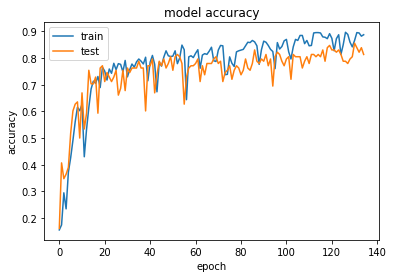

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

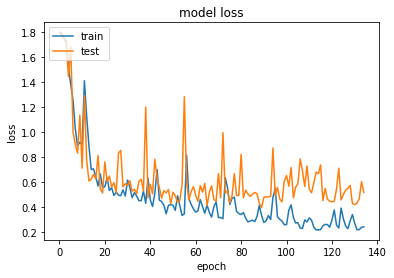

In [37]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [360]:
m2 = third_model()
m2.load_weights(os.path.join(best_model_file_name))

In [361]:
print(
    m2.evaluate(train_X,train_Y),
    m2.evaluate(val_X,val_Y),
    m2.evaluate(test_X,test_Y)
)

4/4 [==============================] - 0s 7ms/step - loss: 0.5554 - accuracy: 0.8600
[0.008823860436677933, 0.9959839582443237] [0.5470543503761292, 0.9067796468734741] [0.5553972125053406, 0.8600000143051147]


In [261]:
print(
    model.evaluate(train_X,train_Y),
    model.evaluate(val_X,val_Y),
    model.evaluate(test_X,test_Y)
)

4/4 [==============================] - 0s 11ms/step - loss: 0.3207 - accuracy: 0.9400
[0.006355493329465389, 0.9986613392829895] [0.5613365173339844, 0.9067796468734741] [0.3207491934299469, 0.9399999976158142]


In [267]:
best_model_file_name = os.path.join("data_aug","arc_3.h5")

tb_callback = TensorBoard(log_dir=os.path.join('Logs'))
checkpoint = ModelCheckpoint(os.path.join(best_model_file_name), monitor='loss', verbose=0,
    save_best_only=True, mode='auto', save_freq=1)
earlyStopping = EarlyStopping(monitor='loss', patience=40)

In [268]:
model = third_model()

In [269]:
model.load_weights(os.path.join(best_model_file_name))

In [248]:
history = model.fit(train_X, train_Y, epochs=70, callbacks=[tb_callback,checkpoint,earlyStopping],validation_data=(val_X,val_Y),batch_size=16)

Epoch 1/70
281/281 [==============================] - 18s 60ms/step - loss: 0.3888 - accuracy: 0.8610 - val_loss: 0.2904 - val_accuracy: 0.9322
Epoch 2/70
281/281 [==============================] - 12s 44ms/step - loss: 0.2501 - accuracy: 0.9018 - val_loss: 0.5411 - val_accuracy: 0.8390
Epoch 3/70
281/281 [==============================] - 20s 70ms/step - loss: 0.2239 - accuracy: 0.9076 - val_loss: 0.3064 - val_accuracy: 0.9322
Epoch 4/70
281/281 [==============================] - 35s 125ms/step - loss: 0.2024 - accuracy: 0.9219 - val_loss: 0.3852 - val_accuracy: 0.8305
Epoch 5/70
281/281 [==============================] - 33s 118ms/step - loss: 0.1880 - accuracy: 0.9268 - val_loss: 0.3665 - val_accuracy: 0.8898
Epoch 6/70
281/281 [==============================] - 33s 118ms/step - loss: 0.1549 - accuracy: 0.9357 - val_loss: 0.9221 - val_accuracy: 0.7203
Epoch 7/70
281/281 [==============================] - 33s 119ms/step - loss: 0.1669 - accuracy: 0.9349 - val_loss: 0.4023 - val_accur

KeyboardInterrupt: 

In [270]:
print(
    model.evaluate(train_X,train_Y),
    model.evaluate(val_X,val_Y),
    model.evaluate(test_X,test_Y)
)

4/4 [==============================] - 0s 8ms/step - loss: 0.4451 - accuracy: 0.9200
[0.046857982873916626, 0.9848281741142273] [0.23211169242858887, 0.8983050584793091] [0.4451363682746887, 0.9200000166893005]


# 5 - test in real time

In [262]:
import numpy as np
import cv2 
import os
import mediapipe as mp
import tensorflow as tf 
from tensorflow import keras
import matplotlib.pyplot as plt
import time
import pandas as pd

In [271]:

def view_probability(res, actions, image):
    #output_frame = input_frame.copy()
    
    output_frame = image
    
    if(type(res)==list or type(res)==np.ndarray):
        max_prob_index = np.argmax(res)
        max_prob = res[max_prob_index]
        text = f'{actions[max_prob_index]} - {max_prob:.3f}'
    else:
        text = "not signing"
    
    
    cv2.rectangle(output_frame, (0,0), (640, 40), (0,255,0), -1)
    cv2.putText(output_frame, text, (0, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame



def view_sentence(sentence,image):
    # output_frame = image.copy()
    output_frame = image
    
    cv2.rectangle(output_frame, (0,430), (640, 480), (255, 0, 0), -1)
    cv2.putText(output_frame, ' '.join(sentence), (3,460), 
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    return output_frame


def compare_frames(prev_frame,current_frame,threshold):
    return True
    if(type(prev_frame) == np.ndarray ):
        diff = cv2.absdiff(prev_frame, current_frame)
        s = diff.sum()
        if(s > threshold):
            return True
        
    return False
    
def evaluate_list_comparisons(s):
    return True
    if(sum(s)>=2):
        return True
    return False

In [272]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

res = None

cap = cv2.VideoCapture(0)
# Set mediapipe model 

last_comparisons = []
holistic = mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5)
prev_frame = None
while cap.isOpened():

    ret, frame = cap.read()
    if(not ret):break
        
    frame = cv2.resize(frame,(512,512))
        
        
    comparison_result = compare_frames(prev_frame,frame,4000000)
    prev_frame = frame
    
    last_comparisons.append(int(comparison_result))
    last_comparisons = last_comparisons[-2:]
    
    
    

    image, results = mediapipe_detection(frame, holistic)
    draw_updated_styled(image, results)

    # 2. Prediction logic
    
    
    if(evaluate_list_comparisons(last_comparisons)):
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-20:]

        if len(sequence) == 20:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            predictions.append(np.argmax(res))


        #3. Viz logic
            if np.unique(predictions[-2:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 

                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]
    else:
        res = None


    image = view_probability(res, actions, image)
    image = view_sentence(sentence,image)
    

    image = cv2.resize(image,(840,640))
    cv2.imshow('OpenCV Feed', image)

    # Break
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [51]:
cap.release()

In [52]:
cv2.destroyAllWindows()

# 6-read video and predict it (for slower models)

In [33]:
def read_video_camera(n_frames,duration=3):
    import time
    
    frames = []
    
    cap = cv2.VideoCapture(0)
    start_time = time.time()
    while cap.isOpened():
        ret, frame = cap.read()
        if(not ret):break
        
        cv2.imshow("frame",frame)
        
        cv2.waitKey(20)
            
        frames.append(frame)
        if(time.time()-start_time > duration):
            break
    cap.release()
    cv2.destroyAllWindows()
    print(len(frames),n_frames)
    steps = len(frames)/n_frames
    count=0
    new_frames=[]
    while count < len(frames):
        frame = frames[int(count)]
        new_frames.append(frame)
        count+=steps
        
    
    return np.array(new_frames[:n_frames])
    
    
def view_video(video):
    for frame in video:
        cv2.imshow("frame",frame)
        cv2.waitKey(100)
    cv2.destroyAllWindows()
    
    
    

        


### read the video from Webcam

In [47]:
video = read_video_camera(n_frames=20,duration=3) # duration is for the human to take his time making the move

74 20


### view the video

In [48]:
view_video(video)

### make prediction

In [49]:
key_points = extract_keypoints_video(video)

In [50]:
predection_array = model.predict(np.expand_dims(key_points, axis=0))[0]
predection_id = np.argmax(predection_array)
predection_label = actions[predection_id]
predection_prob = predection_array[predection_id]
print(predection_label,predection_prob)


tree 1.0


In [131]:
predection_array

array([0.00219467, 0.09042753, 0.15158355, 0.75396156, 0.00183264],
      dtype=float32)

In [104]:
actions

['sister', 'hurry', 'hungry', 'meal', 'tree']

# view confusion matrix between sister & brother